In [1]:
import cv2
import numpy as np
import pandas as pd

from imutils import paths
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.applications import MobileNetV2, ResNet50, EfficientNetB0
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import AveragePooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.utils import to_categorical

In [2]:
def load_image(path, label):
    data = []
    labels = []
    
    imagePaths = list(paths.list_images(path))
    # loop over the image paths
    for imagePath in tqdm(imagePaths, total = len(imagePaths), desc = label + ' image data load'):
        # checking
        image = cv2.imread(imagePath)
        if type(image) is np.ndarray:
            # load the input image (224x224) and preprocess it
            image = load_img(imagePath, target_size = (224, 224))
            image = img_to_array(image)
            image = preprocess_input(image)

            # update the data and labels lists, respectively
            data.append(image)
            labels.append(label)
    
    return data, labels

In [3]:
# construct the head of the model that will be placed on top of the base model
def createHeadModel(baseModel):
    headModel = baseModel.output
    headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(128, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(2, activation="softmax")(headModel)
    
    return headModel

In [4]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

In [5]:
def classification_result(test_Y, pred_Y):
    cm = confusion_matrix(test_Y, pred_Y)
    (TN, FP, FN, TP) = cm.flatten()

    # calculate accuracy
    acc = (float (TP + TN) / float(TP + TN + FP + FN))

    # calculate misclassification
    misclass = 1- acc

    # calculate the sensitivity
    sensitivity = (TP / float(TP + FN))

    # calculate the specificity
    specificity = (TN / float(TN + FP))

    # calculate precision
    precision = (TP / float(TP + FP))

    # calculate f_1 score
    f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))

    print('-'*55)
    print(f'Accuracy : {round(acc, 2)}')
    print(f'Misclassification: {round(misclass, 2)}')
    print(f'Sensitivity : {round(sensitivity, 2)}')
    print(f'Specificity : {round(specificity, 2)}')
    print(f'Precision : {round(precision, 2)}')
    print(f'f1-Score : {round(f1, 2)}')
    print('-'*55)

    # Assigning columns names
    cm_df = pd.DataFrame(cm,
                         columns = ['Predicted Negative', 'Predicted Positive'],
                         index = ['Actual Negative', 'Actual Positive'])

    print(cm_df)

In [6]:
# load image data
img_data = []
img_labels = []

data, labels = load_image(r'./dataset/Image/with_mask', 'with_mask')
img_data += data
img_labels += labels

data, labels = load_image(r'./dataset/Image/without_mask', 'without_mask')
img_data += data
img_labels += labels

In [7]:
# convert the img_data and img_labels to NumPy arrays
img_data = np.array(img_data, dtype = "float32")
img_labels = np.array(img_labels)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
img_labels = lb.fit_transform(img_labels)
img_labels = to_categorical(img_labels)

In [8]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
trainX, testX, trainY, testY = train_test_split(img_data, img_labels, test_size = 0.20, stratify = img_labels, random_state = 42)

In [9]:
models = {
    # load the MobileNetV2 network, ensuring the head FC layer sets are left off
    "MobileNetV2": {
        "base_model": MobileNetV2(weights = "imagenet", include_top = False, input_tensor = Input(shape = (224, 224, 3))),
        "INIT_LR": 1e-4,
        "EPOCHS": 20,
        "BS": 32,
        "model": None
    },
    # load the EfficientNetB0 network, ensuring the head FC layer sets are left off
    "EfficientNetB0": {
        "base_model": EfficientNetB0(weights = "imagenet", include_top = False, input_tensor = Input(shape = (224, 224, 3))),
        "INIT_LR": 1e-4,
        "EPOCHS": 20,
        "BS": 32,
        "model": None
    },
    # load the EfficientNetB0 network, ensuring the head FC layer sets are left off
    "ResNet50": {
        "base_model": ResNet50(weights = "imagenet", include_top = False, input_tensor = Input(shape = (224, 224, 3))),
        "INIT_LR": 1e-4,
        "EPOCHS": 20,
        "BS": 32,
        "model": None
    }
}

for model_key in models:
    baseModel = models[model_key]["base_model"]
    headModel = createHeadModel(baseModel)
    
    # place the head FC model on top of the base model (this will become the actual model we will train)
    model = Model(inputs = baseModel.input, outputs = headModel)
    
    # loop over all layers in the base model and freeze them so they will
    # *not* be updated during the first training process
    for layer in baseModel.layers:
        layer.trainable = False
    
    # initialize the initial learning rate, number of epochs to train for,
    # and batch size
    INIT_LR = models[model_key]["INIT_LR"]
    EPOCHS  = models[model_key]["EPOCHS"]
    BS      = models[model_key]["BS"]
    
    # compile our model
    print("[INFO] Compiling", model_key, "model...")
    opt = Adam(learning_rate = INIT_LR, decay = INIT_LR / EPOCHS)
    model.compile(loss = "binary_crossentropy", optimizer = opt, metrics = ["accuracy"])
    models[model_key]["model"] = model
    print("[INFO] Completed!")

[INFO] Compiling MobileNetV2 model...
[INFO] Completed!
[INFO] Compiling EfficientNetB0 model...
[INFO] Completed!
[INFO] Compiling ResNet50 model...
[INFO] Completed!


In [10]:
# construct the training image generator for data augmentation
imageDataGenerate = ImageDataGenerator(rotation_range = 20, 
                                       zoom_range = 0.15,
                                       width_shift_range = 0.2,
                                       height_shift_range = 0.2,
                                       shear_range = 0.15,
                                       horizontal_flip = True,
                                       fill_mode = "nearest")

In [11]:
# train the head of the network
print("[INFO] training MobileNetV2 head...")
MobileNetV2_hist = models["MobileNetV2"]["model"].fit(
    imageDataGenerate.flow(trainX, trainY, batch_size = BS),
    steps_per_epoch = len(trainX) // BS,
    validation_data = (testX, testY),
    validation_steps = len(testX) // BS,
    epochs = EPOCHS)
print("[INFO] Completed!")

[INFO] training MobileNetV2 head...
Epoch 1/20
149/149 [==============================] - 162s 909ms/step - loss: 0.3294 - accuracy: 0.8876 - val_loss: 0.1502 - val_accuracy: 0.9499
Epoch 2/20
149/149 [==============================] - 126s 847ms/step - loss: 0.1537 - accuracy: 0.9491 - val_loss: 0.1192 - val_accuracy: 0.9508
Epoch 3/20
149/149 [==============================] - 129s 866ms/step - loss: 0.1226 - accuracy: 0.9615 - val_loss: 0.0984 - val_accuracy: 0.9633
Epoch 4/20
149/149 [==============================] - 132s 885ms/step - loss: 0.1052 - accuracy: 0.9641 - val_loss: 0.0878 - val_accuracy: 0.9716
Epoch 5/20
149/149 [==============================] - 130s 876ms/step - loss: 0.0928 - accuracy: 0.9699 - val_loss: 0.0904 - val_accuracy: 0.9633
Epoch 6/20
149/149 [==============================] - 132s 883ms/step - loss: 0.0826 - accuracy: 0.9741 - val_loss: 0.0782 - val_accuracy: 0.9691
Epoch 7/20
149/149 [==============================] - 131s 882ms/step - loss: 0.0779 - a

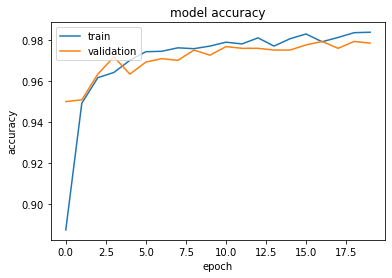

In [12]:
plot_hist(MobileNetV2_hist)

In [13]:
# make predictions on the testing set
print("[INFO] evaluating network...")
MobileNetV2_predIdxs = models["MobileNetV2"]["model"].predict(testX, batch_size=BS)
print("[INFO] Completed!")

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
MobileNetV2_predIdxs = np.argmax(MobileNetV2_predIdxs, axis=1)

[INFO] evaluating network...
38/38 [==============================] - 23s 580ms/step
[INFO] Completed!


In [14]:
print('MobileNetV2')
classification_result(testY.argmax(axis = 1), MobileNetV2_predIdxs)

MobileNetV2
-------------------------------------------------------
Accuracy : 0.98
Misclassification: 0.02
Sensitivity : 0.97
Specificity : 0.99
Precision : 0.99
f1-Score : 0.98
-------------------------------------------------------
                 Predicted Negative  Predicted Positive
Actual Negative                 593                   6
Actual Positive                  20                 579


In [15]:
# train the head of the network
print("[INFO] training EfficientNetB0 head...")
EfficientNetB0_hist = models["EfficientNetB0"]["model"].fit(
    imageDataGenerate.flow(trainX, trainY, batch_size = BS),
    steps_per_epoch = len(trainX) // BS,
    validation_data = (testX, testY),
    validation_steps = len(testX) // BS,
    epochs = EPOCHS)
print("[INFO] Completed!")

[INFO] training EfficientNetB0 head...
Epoch 1/20
149/149 [==============================] - 236s 2s/step - loss: 0.6977 - accuracy: 0.4996 - val_loss: 0.6928 - val_accuracy: 0.5025
Epoch 2/20
149/149 [==============================] - 223s 1s/step - loss: 0.6939 - accuracy: 0.5105 - val_loss: 0.6935 - val_accuracy: 0.5000
Epoch 3/20
149/149 [==============================] - 222s 1s/step - loss: 0.6948 - accuracy: 0.5044 - val_loss: 0.6933 - val_accuracy: 0.5008
Epoch 4/20
149/149 [==============================] - 225s 2s/step - loss: 0.6947 - accuracy: 0.4971 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 5/20
149/149 [==============================] - 229s 2s/step - loss: 0.6938 - accuracy: 0.4922 - val_loss: 0.6928 - val_accuracy: 0.5000
Epoch 6/20
149/149 [==============================] - 228s 2s/step - loss: 0.6933 - accuracy: 0.4975 - val_loss: 0.6928 - val_accuracy: 0.5000
Epoch 7/20
149/149 [==============================] - 227s 2s/step - loss: 0.6930 - accuracy: 0.5084 - 

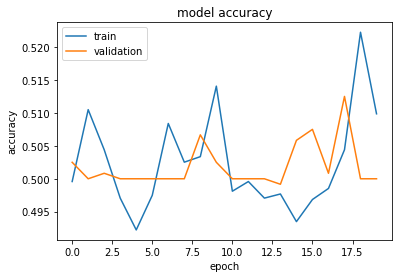

In [16]:
plot_hist(EfficientNetB0_hist)

In [17]:
# make predictions on the testing set
print("[INFO] evaluating network...")
EfficientNetB0_predIdxs = models["EfficientNetB0"]["model"].predict(testX, batch_size=BS)
print("[INFO] Completed!")

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
EfficientNetB0_predIdxs = np.argmax(EfficientNetB0_predIdxs, axis=1)

[INFO] evaluating network...
38/38 [==============================] - 46s 1s/step
[INFO] Completed!


In [18]:
print('EfficientNetB0')
classification_result(testY.argmax(axis = 1), EfficientNetB0_predIdxs)

EfficientNetB0
-------------------------------------------------------
Accuracy : 0.5
Misclassification: 0.5
Sensitivity : 0.0
Specificity : 1.0
Precision : nan
f1-Score : nan
-------------------------------------------------------
                 Predicted Negative  Predicted Positive
Actual Negative                 599                   0
Actual Positive                 599                   0


<ipython-input-5-6e7b034e0532>:18: RuntimeWarning: invalid value encountered in true_divide
  precision = (TP / float(TP + FP))


In [ ]:
# train the head of the network
print("[INFO] training ResNet50 head...")
ResNet50_hist = models["ResNet50"]["model"].fit(
    imageDataGenerate.flow(trainX, trainY, batch_size = BS),
    steps_per_epoch = len(trainX) // BS,
    validation_data = (testX, testY),
    validation_steps = len(testX) // BS,
    epochs = EPOCHS)
print("[INFO] Completed!")

[INFO] training ResNet50 head...
Epoch 1/20
149/149 [==============================] - 403s 3s/step - loss: 0.7160 - accuracy: 0.5336 - val_loss: 0.6633 - val_accuracy: 0.6694
Epoch 2/20
149/149 [==============================] - 399s 3s/step - loss: 0.6709 - accuracy: 0.5803 - val_loss: 0.6441 - val_accuracy: 0.6861
Epoch 3/20
149/149 [==============================] - 373s 3s/step - loss: 0.6533 - accuracy: 0.6427 - val_loss: 0.6269 - val_accuracy: 0.7379
Epoch 4/20
149/149 [==============================] - 393s 3s/step - loss: 0.6415 - accuracy: 0.6629 - val_loss: 0.6100 - val_accuracy: 0.7654
Epoch 5/20
149/149 [==============================] - 389s 3s/step - loss: 0.6300 - accuracy: 0.6696 - val_loss: 0.5969 - val_accuracy: 0.7571
Epoch 6/20
149/149 [==============================] - 391s 3s/step - loss: 0.6210 - accuracy: 0.6847 - val_loss: 0.5860 - val_accuracy: 0.7120
Epoch 7/20
149/149 [==============================] - 387s 3s/step - loss: 0.6111 - accuracy: 0.7009 - val_lo

In [ ]:
plot_hist(ResNet50_hist)

In [ ]:
# make predictions on the testing set
print("[INFO] evaluating network...")
ResNet50_predIdxs = models["ResNet50"]["model"].predict(testX, batch_size=BS)
print("[INFO] Completed!")

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
ResNet50_predIdxs = np.argmax(ResNet50_predIdxs, axis=1)

In [ ]:
print('ResNet50')
classification_result(testY.argmax(axis = 1), ResNet50_predIdxs)

In [ ]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
models["MobileNetV2"]["model"].save("./model/MobileNetV2_face_mask_detector_without_SR.model", save_format = "h5")
models["EfficientNetB0"]["model"].save("./model/EfficientNetB0_face_mask_detector_without_SR.model", save_format = "h5")
models["ResNet50"]["model"].save("./model/ResNet50_face_mask_detector_without_SR.model", save_format = "h5")